This analysis does the following:
- extracts CNN and FOX articles
- Loads text for respective articles
- breaks CNN and FOX NEWS articles down into bigrams and trigrams
    - displays charts for each
- Analyze polarity and subjectivity for top n-grams in each category

In [72]:
import os
os.chdir("..")

from data.nela2017 import Nela2017
from utils.text.preprocess import preprocess, STOPWORDS
from utils.text.analysis import sentiment
from utils.plotting.plotting import box_and_whisker
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from textblob import TextBlob
from nltk.util import bigrams, trigrams

In [73]:
sns.set_theme()

In [2]:
ROOT = "C:/Users/alexander.paskal/datasets/NELA2017"  # change to wherever you have the data

In [3]:
dataset = Nela2017(ROOT)

In [4]:
dataset.organizations("FOX NEWS", "CNN")
df = dataset.df()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4776 entries, 0 to 4775
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      4776 non-null   object
 1   path    4776 non-null   object
 2   org     4776 non-null   object
 3   date    4776 non-null   object
 4   title   4776 non-null   object
 5   text    4776 non-null   object
 6   author  4776 non-null   object
dtypes: object(7)
memory usage: 261.3+ KB


In [10]:
df["text_pp"] = df["text"].apply(preprocess).apply(lambda x: " ".join(x))

In [29]:
df["tokens"] = df["text_pp"].apply(nltk.word_tokenize)

In [15]:
df["polarity"] = df['text_pp'].apply(lambda x: TextBlob(x).polarity)
df["polarity"]

0       0.075513
1       0.116000
2       0.114228
3       0.127068
4       0.021899
          ...   
4771   -0.005291
4772    0.058333
4773    0.022454
4774    0.041225
4775    0.007047
Name: polarity, Length: 4776, dtype: float64

In [16]:
df["subjectivity"] = df['text_pp'].apply(lambda x: TextBlob(x).subjectivity)
df["subjectivity"]

0       0.446330
1       0.339333
2       0.349568
3       0.466917
4       0.484177
          ...   
4771    0.410317
4772    0.233333
4773    0.382407
4774    0.456252
4775    0.352311
Name: subjectivity, Length: 4776, dtype: float64

In [53]:
c_vec = CountVectorizer(stop_words=STOPWORDS, ngram_range=(2,))
df["bigrams"] = df["tokens"].apply(lambda x: tuple(bigrams(x)))
df["trigrams"] = df["tokens"].apply(lambda x: tuple(trigrams(x)))

In [54]:
df["trigrams"]

0       ((Heightening, concern, US), (concern, US, int...
1       ((But, Friday, afternoon), (Friday, afternoon,...
2       ((Harris, threeterm, congressman), (threeterm,...
3       ((Washington, CNN, Sen), (CNN, Sen, Claire), (...
4       ((CNN, US, Navy), (US, Navy, veteran), (Navy, ...
                              ...                        
4771    ((I, think, reaction), (think, reaction, admin...
4772    ((The, portraits, men), (portraits, men, smili...
4773    ((Last, Monday, White), (Monday, White, House)...
4774    ((Justice, Department, special), (Department, ...
4775    ((CNN, Justice, Department), (Justice, Departm...
Name: trigrams, Length: 4776, dtype: object

In [55]:
og_df = df

In [99]:
def extract_trigrams(df, kw):
    trigrams = []
    for trigram_group in df.trigrams:
        for trigram in trigram_group:
            for word in trigram:
                if kw.lower() in word.lower():
                    trigrams.append(trigram)
                    break
    return trigrams


def trigram_sentiment(df, kw, org=None):
    if org is not None:
        df = df[df.org.str.lower() == org.lower()]
    
    trigrams = extract_trigrams(df, kw)
    
    polarities = []
    subjectivities = []
    for trigram in trigrams:
        text = " ".join(trigram)
        polarity = TextBlob(text).polarity
        subjectivity = TextBlob(text).subjectivity
        if polarity != 0:
            polarities.append(polarity)
        if subjectivity != 0:
            subjectivities.append(subjectivity)
    
    result = {
        "polarity": polarities, 
        "subjectivity": subjectivities
    }
    return result
    
    
def text_sentiment(df, kw, org=None):
    if org is not None:
        df = df[df.org.str.lower() == org.lower()]
    
    result = {
        "polarity": list(df.polarity),
        "subjectivity": list(df.subjectivity)
    }
    
    return result


def sentence_sentiment(df, kw, org=None):
    if org is not None:
        df = df[df.org.str.lower() == org.lower()]
    
    
    polarities = []
    subjectivities = []
    
    series = df["text"].str.split('.')
    for sentences in series:
        for sentence in sentences:
            text = preprocess(sentence, tokenized=False)
            polarity = TextBlob(text).polarity
            subjectivity = TextBlob(text).subjectivity
            polarities.append(polarity)
            subjectivities.append(subjectivity)
            
    result = {
        "polarity": list(df.polarity),
        "subjectivity": list(df.subjectivity)
    }
    
    return result

In [ ]:
trigram_cnn = trigram_sentiment(df, "trump", org="CNN")
trigram_fox = trigram_sentiment(df, "trump", org="FOX NEWS")

In [85]:

text_fox = text_sentiment(df, "trump", org="FOX NEWS")
text_cnn = text_sentiment(df, "trump", org="CNN")

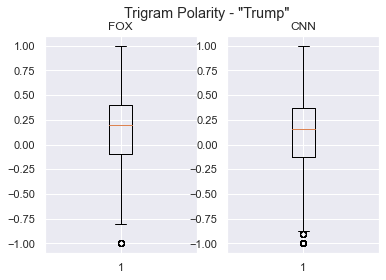

In [81]:
fig, axs = plt.subplots(1, 2)

box_and_whisker(fox_sentiment["polarity"], ax=axs[0])
box_and_whisker(cnn_sentiment["polarity"], ax=axs[1])

fig.suptitle("Trigram Polarity - \"Trump\"")
axs[0].set_title("FOX")
axs[1].set_title("CNN")
plt.show()

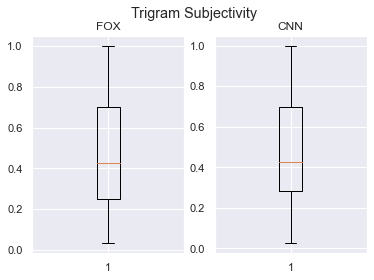

In [79]:
fig, axs = plt.subplots(1, 2)

box_and_whisker(fox_sentiment["subjectivity"], ax=axs[0])
box_and_whisker(cnn_sentiment["subjectivity"], ax=axs[1])

fig.suptitle("Trigram Subjectivity - \"Trump\""")
axs[0].set_title("FOX")
axs[1].set_title("CNN")
plt.show()

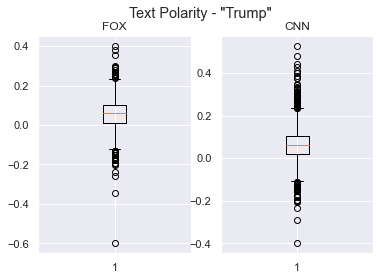

In [87]:
fig, axs = plt.subplots(1, 2)

box_and_whisker(text_fox["polarity"], ax=axs[0])
box_and_whisker(text_cnn["polarity"], ax=axs[1])

fig.suptitle("Text Polarity - \"Trump\"")
axs[0].set_title("FOX")
axs[1].set_title("CNN")
plt.show()

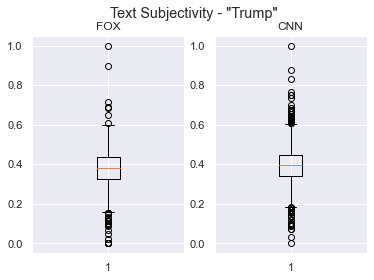

In [89]:
fig, axs = plt.subplots(1, 2)

box_and_whisker(text_fox["subjectivity"], ax=axs[0])
box_and_whisker(text_cnn["subjectivity"], ax=axs[1])

fig.suptitle("Text Subjectivity - \"Trump\"")
axs[0].set_title("FOX")
axs[1].set_title("CNN")
plt.show()

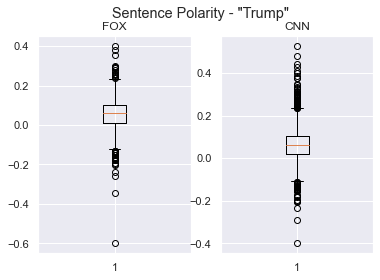

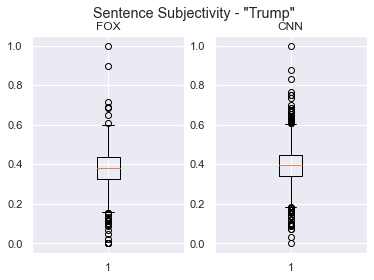

In [101]:
# sentence_fox = sentence_sentiment(df, "trump", org="FOX NEWS")
# sentence_cnn = sentence_sentiment(df, "trump", org="CNN")


fig, axs = plt.subplots(1, 2)

box_and_whisker(sentence_fox["polarity"], ax=axs[0])
box_and_whisker(sentence_cnn["polarity"], ax=axs[1])

fig.suptitle("Sentence Polarity - \"Trump\"")
axs[0].set_title("FOX")
axs[1].set_title("CNN")
plt.show()
fig, axs = plt.subplots(1, 2)

box_and_whisker(sentence_fox["subjectivity"], ax=axs[0])
box_and_whisker(sentence_cnn["subjectivity"], ax=axs[1])

fig.suptitle("Sentence Subjectivity - \"Trump\"")
axs[0].set_title("FOX")
axs[1].set_title("CNN")
plt.show()